In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import matplotlib 
from PIL import Image
import PIL
import math
from random import random
from random import seed
from random import randint
import time
from numba import jit
import skimage

In [19]:
@jit(nopython = True)
    
def Laplacian(A,deltax,deltat):

    h = len(A)
    #CFL condition delta x => sqrt(D) delta t, where D is the number of dimensions            
    P = np.zeros((h,h))
    result = np.zeros((h,h))
    
    for i in range(0, h):
        for j in range(0,h):
            P[i,j] = (-A[(i+2)%h,j] + 16*A[(i+1)%h,j] + 16*A[(i-1)%h,j] -A[(i-2)%h,j] \
                 -A[i,(j+2)%h] + 16*A[i,(j+1)%h]  + 16*A[i,(j-1)%h] -A[i,(j-2)%h] - 60*A[i,j])/(12*pow(deltax,2))

  
    return P 

def damping(t,K_damp):
    Damping = np.zeros(shape=int(t/deltat))
    Damping[0:200] = 1*K_damp
    return Damping

def div_potential_1(A1,A2,omega,eta):
    lam = 2*pow(math.pi,2)/pow(omega,2)
    pot = lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2))
    return pot

def div_potential_2(A1,A2,omega,eta):
    lam = 2*pow(math.pi,2)/pow(omega,2)
    pot = lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2))
    return pot
    
def function_1(A1,A2,vel1,omega,eta,deltax,deltat,index,Damping):
    F = np.subtract(Laplacian(A1,deltax,deltat),div_potential_1(A1,A2,omega,eta)) - Damping[int(index)]*vel1
    return F

def function_2(A1,A2,vel2,omega,eta,deltax,deltat,index,Damping):
    F = np.subtract(Laplacian(A2,deltax,deltat),div_potential_2(A1,A2,omega,eta)) - Damping[int(index)]*vel2
    return F

def update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,index,Damping):
    F1 = function_1(A1,A2,vel1,omega,eta,deltax,deltat,index,Damping)
    F2 = function_2(A1,A2,vel2,omega,eta,deltax,deltat,index,Damping)
    
    B1 = A1
    
    A1 = A1 + deltat*(vel1 + 0.5*deltat*function_1(A1,A2,vel1,omega,eta,deltax,deltat,index,Damping)) 
    A2 = A2 + deltat*(vel2 + 0.5*deltat*function_2(B1,A2,vel2,omega,eta,deltax,deltat,index,Damping)) 
    
    vel1 = vel1 + deltat/2*(F1 + function_1(A1,A2,vel1,omega,eta,deltax,deltat,index,Damping)) 
    vel2 = vel2 + deltat/2*(F2 + function_2(A1,A2,vel2,omega,eta,deltax,deltat,index,Damping))
    return A1,A2,vel1,vel2
    
#change the values accordlingly    
def wolff(N,t,A1,A2,vel,omega,eta,deltax,deltat,K_damp):


    Damping = damping(t,K_damp)

    vel1 = vel
    vel2 = vel
    
    fig, ax = plt.subplots(1, 2,figsize=(10,10))

    #ax[0].axis('off')
    #ax[1].axis('off')
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    
    plt.ioff()
    plt.show()
    cbax = fig.add_axes([0.04,0.2,0.03,0.6])
    cbay = fig.add_axes([0.93,0.2,0.03,0.6])
    x = np.arange(A1.shape[0])
    y = np.arange(A1.shape[1])
    X,Y = np.meshgrid(x,y)
    
    for i in np.arange(int(t/deltat)):
        
        fig.suptitle('time= '+str(round((i*deltat),1))+'')
        mod = np.sqrt(pow(A1,2)+pow(A2,2))
        
        if i == 0:
            first = ax[0].imshow(mod, vmin= 0, vmax=1.5*round(eta),cmap = 'Greys', interpolation = 'none')
            ax[0].contour(X,Y,mod,levels = [0.5])
            fig.colorbar(first,orientation = 'vertical',cax = cbax)
            second = ax[1].imshow(np.arctan2(A2,A1), vmin= -1*math.pi, vmax=math.pi,cmap = 'twilight', interpolation = 'none')
            fig.colorbar(second,orientation = 'vertical',cax = cbay)
            
            fig.savefig('Contours/'+str(round((i*deltat),1))+'.png')
            A1,A2,vel1,vel2 = update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,i,Damping)
        #print([A1[0,0],A2[0,0]])
        
        

        
        if i != 0:
            ax[0].imshow(mod, vmin= 0, vmax=1.5*round(eta),cmap = 'Greys',interpolation = 'none')
            ax[0].contour(X,Y,mod, levels = [0.5])
            ax[1].imshow(np.arctan2(A2,A1), vmin= -1*math.pi, vmax=math.pi,cmap = 'twilight', interpolation = 'none')
  
            fig.savefig('Contours/'+str(round((i*deltat),1))+'.png')
            #plt.pause(1)
            ax[0].clear()
            A1,A2,vel1,vel2 = update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,i,Damping)
            

    return A1,A2


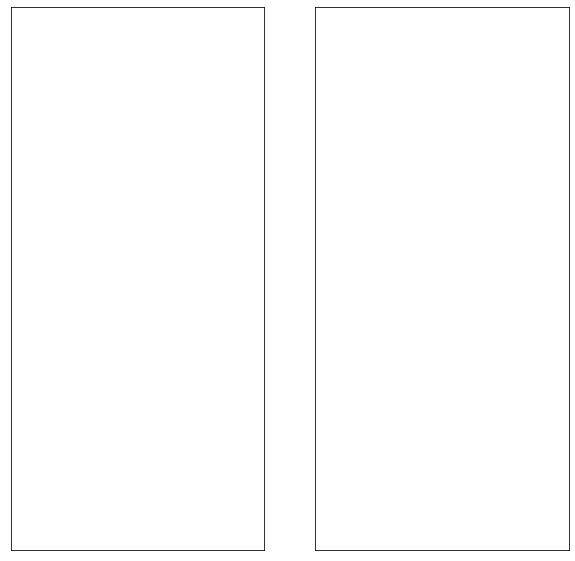

<ipython-input-19-12e17c37960c>:87: UserWarning: No contour levels were found within the data range.
  ax[0].contour(X,Y,mod,levels = [0.5])
<ipython-input-19-12e17c37960c>:101: UserWarning: No contour levels were found within the data range.
  ax[0].contour(X,Y,mod, levels = [0.5])


ValueError: not enough values to unpack (expected 3, got 2)

In [20]:
start = time.time()

K_damp = 1
n = 7
deltax = 1
deltat = 0.1
eta = 1
N = pow(2,n)
t = 0.5*N*deltax/deltat # light crossing time
t2 = t/2 # half time
t10 = t/10 # 1/10 of the ligth crossing time
vel = np.zeros((N,N))
mu, sigma = 0, 0.1 # mean and standard deviation
omega = 5


#A = np.random.randn(N, 2*N).view(np.complex128)   

A1 = np.random.normal(mu, sigma, size=(N, N))
A2 = np.random.normal(mu,sigma,size=(N,N))
A1,A2 = wolff(N,t10,A1,A2,vel,omega,eta,deltax,deltat,K_damp)

end = time.time()
print(end - start)